In [1]:
import genophenocorr
import hpotk
from IPython.display import display, HTML
store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.1.1dev


In [2]:
ANKRD11_id = 'NM_013275.6' # MANE select
from genophenocorr.preprocessing import configure_caching_cohort_creator, load_phenopacket_folder

fpath_phenopackets = r'C:\Users\filip\OneDrive\Documents\dataspell\genophenocorr\notebooks\ANKRD11\phenopackets'
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
cohort = load_phenopacket_folder(fpath_phenopackets, cohort_creator)


Patients Created: 100%|██████████| 337/337 [00:01<00:00, 323.08it/s]
Validated under none policy
Showing errors and warnings
337 phenopacket(s) found at `C:\Users\filip\OneDrive\Documents\dataspell\genophenocorr\notebooks\ANKRD11\phenopackets`
  patient #1
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Behnert, 2018[PMID_36446582_Behnert_2018]. Remove variant from testing
     ·Patient PMID_36446582_Behnert_2018 has no variants to work with
  patient #3
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Bucerzan2020[PMID_36446582_Bucerzan2020]. Remove variant from testing
     ·Patient PMID_36446582_Bucerzan2020 has no variants to work with
  patient #4
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Crip

In [3]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.analysis.predicate import PatientCategories

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = True
analysis_config.pval_correction = 'fdr_bh'
analysis_config.min_perc_patients_w_hpo = 0.1
#analysis_config.heuristic_strategy()
analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

In [4]:
# from genophenocorr.model import VariantEffect
# 
# frameshift = analysis.compare_by_variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=ANKRD11_id)
# frameshift.summarize(hpo, PatientCategories.YES)

In [5]:
protein_id = 'NP_001027558.1'
from genophenocorr.preprocessing import UniprotProteinMetadataService
pms = UniprotProteinMetadataService()
protein_metas = pms.annotate(protein_id)


from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService

txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(ANKRD11_id)

sum = 0
for exon in tx_coordinates.exons:
    if exon.end > tx_coordinates.cds_start and exon.start < tx_coordinates.cds_end:
        if exon.start < tx_coordinates.cds_start < exon.end:
            # case 1: first exon in cds: starts in the middle and ends with exon.end
            sum += exon.end - tx_coordinates.cds_start
        elif tx_coordinates.cds_start < exon.start < exon.end <= tx_coordinates.cds_end:
            # case 2: exon prior to pos: exon.start to exon.end
            sum += exon.end - exon.start
        elif exon.start < tx_coordinates.cds_end < exon.end:
            # case 1: first exon in cds: starts in the middle and ends with exon.end
            sum += tx_coordinates.cds_end - exon.start
        
print(sum)
print(sum/3)

7992
2664.0


10000.0


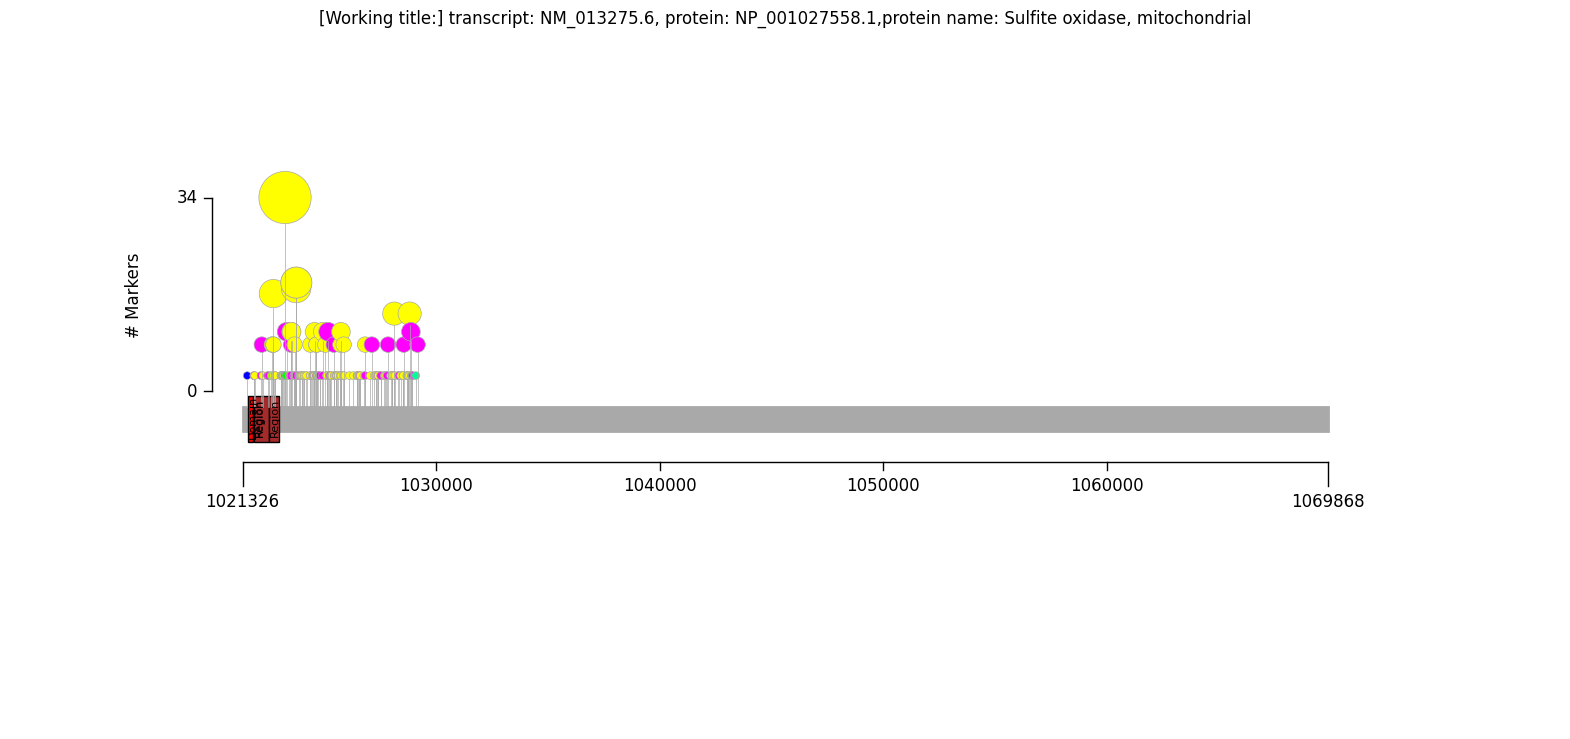

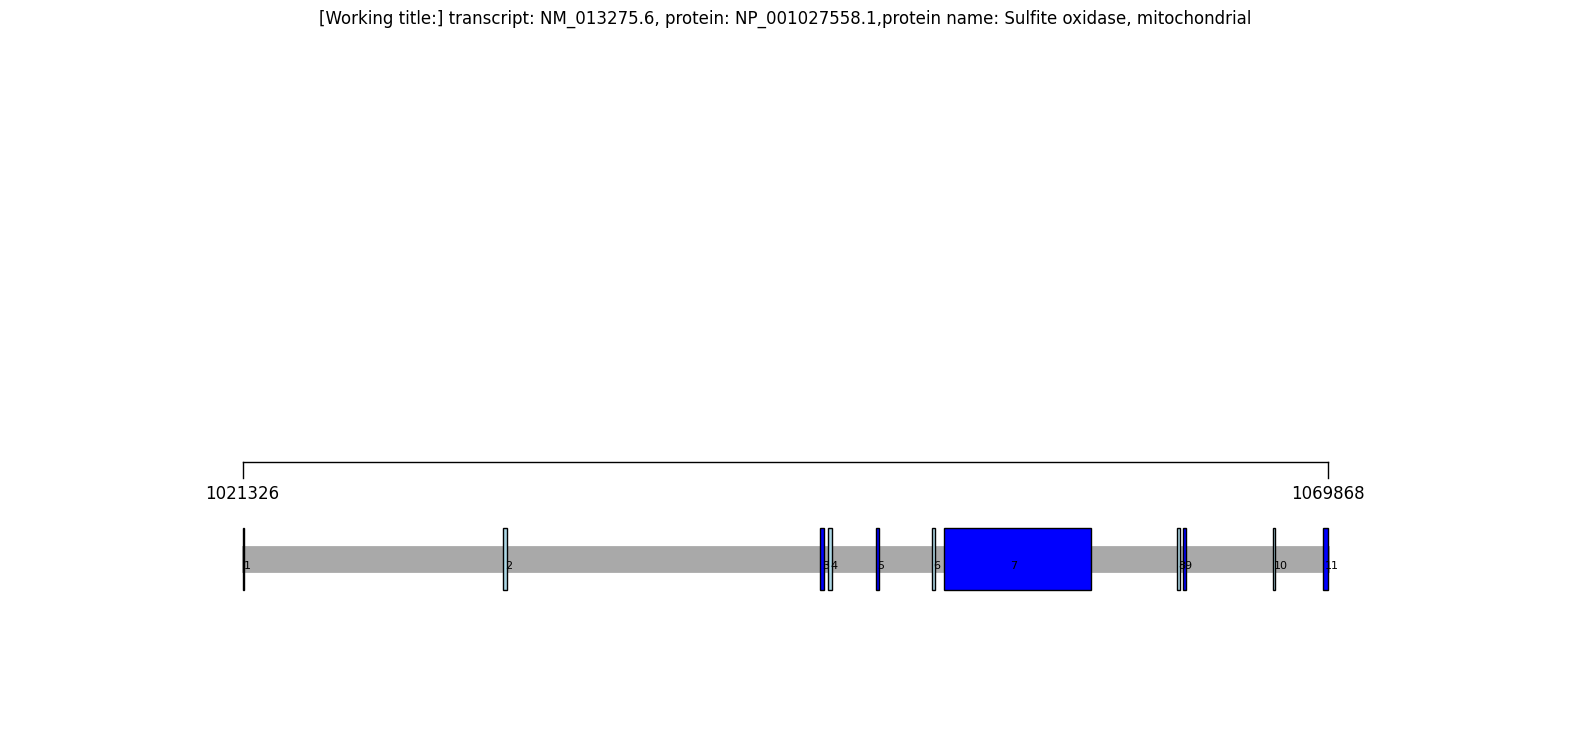

In [6]:
assert len(protein_metas) == 1
protein_meta = protein_metas[0]
from genophenocorr.view._draw_variants import ProteinVariantVisualizer
viz = ProteinVariantVisualizer()
viz.draw_fig(tx_coordinates, protein_meta, cohort)

from genophenocorr.view._draw_variants import GenomicVariantVisualizer
viz = GenomicVariantVisualizer()
viz.draw_fig(tx_coordinates, protein_meta, cohort)

In [7]:
from genophenocorr.view._draw_variants import _calc_aa_based_pos

print(tx_coordinates.cds_start, tx_coordinates.cds_end)

print(_calc_aa_based_pos(1021819, tx_coordinates))

1021326 1069868
pos_bases=1021819
GenomicRegion(contig=16, start=1021267, end=1021413, strand=-)
adding exon.end=1021413 - 1021326 = 87
GenomicRegion(contig=16, start=1033001, end=1033140, strand=-)
29


In [8]:
import pandas as pd

In [9]:
from genophenocorr.model import VariantEffect
effect = VariantEffect.MISSENSE_VARIANT
yes = PatientCategories.YES
no = PatientCategories.NO
#GenotypeBooleanPredicate.YES, GenotypeBooleanPredicate.NO

df = pd.DataFrame({PatientCategories.YES: [0, 2], PatientCategories.NO: [11, 6]})


In [10]:
df

,Yes,No
0,0,11
1,2,6
